In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import os
import time

import camb
from camb import model, initialpower
print('Using CAMB %s installed at %s'%(camb.__version__,os.path.dirname(camb.__file__)))

import anzu
import scipy.integrate as integrate
import scipy.interpolate as interp
import scipy.misc as misc

from anzu.emu_funcs import LPTEmulator
import twopoint.twopoint as twopoint
%load_ext autoreload
%autoreload 2

import os
os.environ['PATH'] = '/global/common/sw/cray/sles15/x86_64/texlive/live/gcc/8.2.0/tiozj27/bin/x86_64-linux/:{}'.format(os.environ['PATH'])

from matplotlib import rc
rc('font',**{'size':'20','family':'serif','serif':['CMU serif']})
rc('mathtext', **{'fontset':'cm'})
rc('text', usetex=True)
rc('legend',**{'fontsize':'13'})


import warnings
warnings.filterwarnings('ignore')

import time


Using CAMB 1.1.3 installed at /global/homes/n/nishant/.conda/envs/cobaya/lib/python3.8/site-packages/camb


In [2]:
from scipy.special import hyp2f1

def D_of_a(a,OmegaM=1):
    return a * hyp2f1(1./3,1,11./6,-a**3/OmegaM*(1-OmegaM)) / hyp2f1(1./3,1,11./6,-1/OmegaM*(1-OmegaM))

def D_of_z(z, omega_m=1):
    a = 1/(1+z)
    return D_of_a(a, OmegaM=1)

def f_of_a(a, OmegaM=1):
    Da = D_of_a(a,OmegaM=OmegaM)
    ret = Da/a - a*(6*a**2 * (1 - OmegaM) * hyp2f1(4./3, 2, 17./6, -a**3 *  (1 - OmegaM)/OmegaM))/(11*OmegaM)/hyp2f1(1./3,1,11./6,-1/OmegaM*(1-OmegaM))
    return a * ret / Da

In [3]:
#Set up a new set of parameters for CAMB
pars = camb.CAMBparams()

sigma8 = 0.82
ns=0.96
h=0.7
omega_b=0.046
omega_m=0.286
w=-1
#This function sets up CosmoMC-like settings, with one massive neutrino and helium set using BBN consistency
pars.set_cosmology(H0=h*100, ombh2=omega_b*h**2, omch2=(omega_m - omega_b)*h**2, mnu=0.06, omk=0, tau=0.06)
pars.InitPower.set_params(As=2e-9, ns=ns, r=0)
pars.set_for_lmax(2500, lens_potential_accuracy=0);

#calculate results for these parameters
results = camb.get_results(pars)

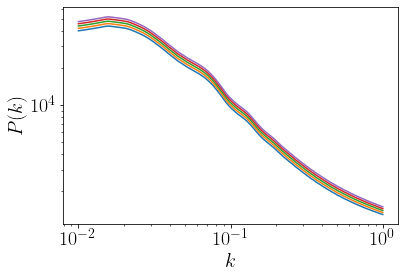

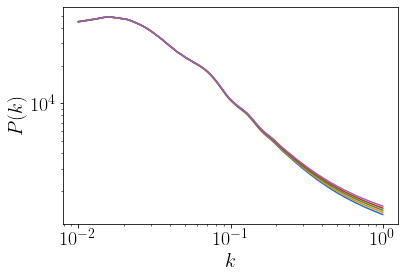

In [4]:
emu = LPTEmulator()

wave_density = 102

k = np.logspace(-2,0,wave_density)
cosmo_vec = np.atleast_2d([omega_b*h**2, (omega_m - omega_b)*h**2, w, ns, sigma8,  h*100,  3.046,  1.0])

emu_spec = emu.predict(k, cosmo_vec)
#0,0 is matter-matter

#UNIT-redmagic bias parameters from 2101.11014
#         b1,    b2,    bs2,   bnabla2, SN
for num in np.linspace(.6,.9,5):
    bvec = [num, 0.583, -0.406, -0.512, 1755]

    biased_spec = emu.basis_to_full(k, bvec, emu_spec[0])

    mm = emu_spec[0,0,:]
    gg = biased_spec[::wave_density]
    mg = biased_spec[wave_density::]

    plt.plot(k, mg)
plt.xscale('log')
plt.yscale('log')
plt.ylabel('$P(k)$')
plt.xlabel('$k$')
plt.show()

for num in np.linspace(.3,.8,5):
    bvec = [0.786, num, -0.406, -0.512, 1755]

    biased_spec = emu.basis_to_full(k, bvec, emu_spec[0])

    mm = emu_spec[0,0,:]
    gg = biased_spec[::wave_density]
    mg = biased_spec[wave_density::]

    plt.plot(k, mg)
plt.xscale('log')
plt.yscale('log')
plt.ylabel('$P(k)$')
plt.xlabel('$k$')
plt.show()


In [5]:
print(len(T1.kernels[0].nzs[0]))

NameError: name 'T1' is not defined

[<astropy.io.fits.hdu.image.PrimaryHDU object at 0x2aaada70ab80>, <astropy.io.fits.hdu.image.ImageHDU object at 0x2aaada70a850>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x2aaada70a5b0>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x2aaada70a400>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x2aaada70a940>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x2aaada70a970>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x2aaada70a340>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x2aaada70afa0>]


<Figure size 432x288 with 0 Axes>

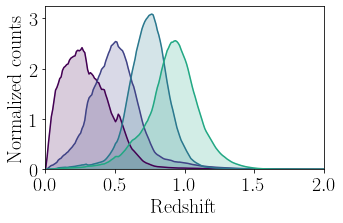

<Figure size 432x288 with 0 Axes>

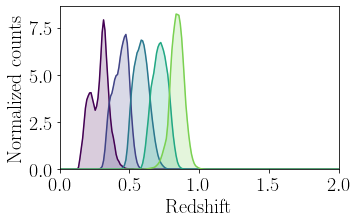

[<twopoint.twopoint.twopoint.NumberDensity object at 0x2aaadc58eca0>, <twopoint.twopoint.twopoint.NumberDensity object at 0x2aaadc58ecd0>]


In [6]:
from astropy.io import fits

filename1 = 'map_prediction_chain_2x2pt_fixedcosmo_free_mag_pm_samp_buzzard_mean_dv_16_sompz_bin_zs_true_true_zl_no_sn_no_jk_20xrand_bNGcov.fits_scales_3x2pt_0.5_8_6_v0.4.ini_lcdm_scaledrsd.txt'


test = fits.open(filename1 +'.fits')

print(list(test))

T1 = twopoint.TwoPointFile.from_fits(filename1 + '.fits')

colormap='viridis'
print

for kernel in T1.kernels:
   # name = "{}_{}".format(root, kernel.name)
    plt.figure()
    fig, ax = plt.subplots(1, 1, figsize=(5, 3))
    for i, nz in enumerate(kernel.nzs):
        color = color = plt.get_cmap(colormap)(0.2*i)
        ax.plot(kernel.z, nz, lw=1.5, color=color)
        zmid = sum(kernel.z * nz * (kernel.zhigh - kernel.zlow))
        ax.fill_between(kernel.z, 0, nz, color=color, alpha=0.2)
    ax.set_xlabel('Redshift')
    ax.set_ylabel('Normalized counts')
    ax.set_xlim(0, 2)
    ax.set_ylim(bottom=0)
    
    plt.show()

print(T1.kernels)

In [7]:
comoving_radial_distance = np.vectorize(results.comoving_radial_distance)

In [8]:
print(max(kernel.z))
print(kernel.z[-1])

3.9951000000000003
3.9951000000000003


0
69.99999999998728
nz_source
1
69.99999999998728
nz_source
2
69.99999999998728
nz_source
3
69.99999999998728
nz_source
0
69.99999999998728
nz_lens
1
69.99999999998728
nz_lens
2
69.99999999998728
nz_lens
3
69.99999999998728
nz_lens
4
69.99999999998728
nz_lens


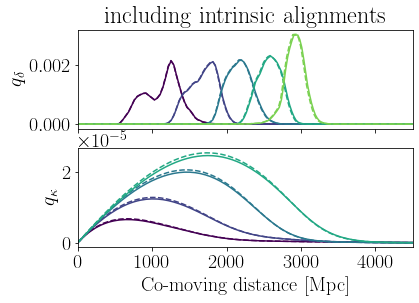

In [9]:
c = 3e5
plot=True
q_delt = np.zeros(shape=(len(T1.kernels[1].nzs), len(T1.kernels[1].z)))
q_kappa = np.zeros(shape=(len(T1.kernels[1].nzs), len(T1.kernels[1].z)))
ia=False
fig, axs = plt.subplots(2, sharex=True)

for kernel in T1.kernels:
   # name = "{}_{}".format(root, kernel.name)

    
    for i, nz in enumerate(kernel.nzs):
        print(i)
        #nz_func = interp.interp1d(kernel.z[1::], nz[1::])
        nz_bar = integrate.simps(nz, x=kernel.z)
        #hubble_rate uses h_of_z
        H_z = results.hubble_parameter(kernel.z)
        H_0 = H_z[0]
        print(H_0)
        D_z = D_of_z(kernel.z, omega_m)
        a = 1 / (1 + kernel.z)
        
        background_densities = results.get_background_densities(a=1.0)
        Omega_m = (background_densities['cdm'] + background_densities['baryon'])/background_densities['tot']
        chi = comoving_radial_distance(kernel.z, tol=0.0001)

        #z_chi = interp.interp1d(chi, kernel.z)
        #chi_z = interp.interp1d(kernel.z, chi)
        
        dz_div_dchi = H_z/c #np.gradient(kernel.z, chi, edge_order=2)
        #dz_div_dchi = misc.derivative(chi_z, chi)

        q_delta_temp = np.zeros(shape=kernel.z.shape[0])
        q_kappa_temp = np.zeros(shape=kernel.z.shape[0])
        
        chi_h = results.sound_horizon(z=0)
        color = plt.get_cmap(colormap)(0.2*i)
        print(kernel.name)
        if kernel.name == 'nz_lens':
            q_delt_temp = nz/nz_bar * dz_div_dchi
            q_delt[i, :] = q_delt_temp
            
            
            
            if plot:
                axs[0].plot(chi, q_delt_temp, color=color)
                stuff = np.loadtxt('lens_kernels.txt')
                axs[0].plot(stuff[:,0], stuff[:,i+1],'--', color=color)
                
                
        if kernel.name == 'nz_source': 
            prefix = 3 * H_0**2 * Omega_m / ( 2 * c**2) * (chi/a)
            
            for num in range(len(q_kappa_temp)):
                chi_test = chi[num]

                integrand = nz/nz_bar * dz_div_dchi * ((chi) - chi_test)/chi

                #integrand_interp = interp.interp1d(chi, np.nan_to_num(integrand))

                q_kappa_temp[num] = integrate.simps(integrand[num::], x=chi[num::])
                
                
                
            q_kappa_temp = prefix * q_kappa_temp
            q_kappa[i, :] = q_kappa_temp
            
            if ia:
                z_0 = 0.62
                C = 0.0134
                A_0 = .64#.44
                alpha = 0
                A = A_0 * ((1+kernel.z)/(1+z_0))**alpha * C / D_z
                print('doing')
                q_kappa_temp = q_kappa_temp - A * nz/nz_bar * dz_div_dchi

            if plot:
                axs[1].plot(chi, q_kappa_temp, color=color)
                stuff = np.loadtxt('source_kernels.txt')
                axs[1].plot(stuff[:,0], stuff[:,i+1],'--', color=color)
                axs[0].set_title('including intrinsic alignments')
            q_kappa[i, :] = q_kappa_temp
            
axs[0].set_ylabel('$q_{\delta}$')
axs[1].set_ylabel('$q_{\kappa}$')



#axs[0].set_xlabel('Co-moving distance [Mpc]')
axs[1].set_xlabel('Co-moving distance [Mpc]')
axs[0].set_xlim(0, 4500)
#axs[0].set_xscale('log')
#axs[0].set_yscale('log')
#axs[1].set_xscale('log')
#axs[1].set_yscale('log')

plt.savefig('kernels.png', dpi=200, bbox_inches='tight')
plt.show()


In [10]:
print(q_kappa.shape)
print(stuff.shape)

(5, 401)
(400, 6)


In [11]:
start = time.time()


#hubble_rate uses h_of_z
H_z = results.hubble_parameter(kernel.z)
H_0 = H_z[0]
h=H_0/100
a = 1 / (1 + kernel.z)

background_densities = results.get_background_densities(a=1.0)
Omega_m = (background_densities['cdm'] + background_densities['baryon'])/background_densities['tot']

chi = comoving_radial_distance(kernel.z, tol=0.0001)

emu = LPTEmulator(kecleft=True)

wave_density = 1000

k_range = np.logspace(-3,-0.177, wave_density)

tomographic_bins = np.array([])


power_spectra = np.zeros(shape=(len(kernel.z), 3, wave_density))

kernel = T1.kernels[0]


for i, redshift in enumerate(kernel.z):
    a = 1/(1+redshift)

    cosmo_vec = np.atleast_2d([omega_b*h**2, (omega_m - omega_b)*h**2, w, ns, sigma8,  h*100,  3.046,  a])
    emu_spec = emu.predict(k_range/h, cosmo_vec)

    bvec = [0.77, 0.0, 0.0, 0.0, 0]

    biased_spec = emu.basis_to_full(k_range/h, bvec, emu_spec[0])

    power_spectra[i, 0, :] = emu_spec[0,0,:]/h**3
    power_spectra[i, 1, :] = biased_spec[0:wave_density]/h**3
    power_spectra[i, 2, :] = biased_spec[wave_density::]/h**3
    print(i, redshift)
    #redshift, mm/gg/mg, k_value
    
end = time.time()
print(end - start, ' seconds')

0 0.0
1 0.0051
2 0.015099999999999999
3 0.0251
4 0.035100000000000006
5 0.0451
6 0.0551
7 0.0651
8 0.07510000000000001
9 0.0851
10 0.0951
11 0.10510000000000001
12 0.1151
13 0.1251
14 0.1351
15 0.1451
16 0.1551
17 0.1651
18 0.17509999999999998
19 0.1851
20 0.1951
21 0.2051
22 0.21509999999999999
23 0.2251
24 0.23509999999999998
25 0.24509999999999998
26 0.2551
27 0.2651
28 0.2751
29 0.2851
30 0.2951
31 0.3051
32 0.3151
33 0.3251
34 0.3351
35 0.3451
36 0.35509999999999997
37 0.3651
38 0.3751
39 0.3851
40 0.3951
41 0.4051
42 0.4151
43 0.4251
44 0.4351
45 0.4451
46 0.4551
47 0.4651
48 0.47509999999999997
49 0.4851
50 0.4951
51 0.5051
52 0.5151
53 0.5251
54 0.5351
55 0.5451
56 0.5551
57 0.5651
58 0.5751
59 0.5851
60 0.5951
61 0.6051
62 0.6151
63 0.6251
64 0.6351
65 0.6451
66 0.6551
67 0.6651
68 0.6751
69 0.6851
70 0.6951
71 0.7051000000000001
72 0.7151
73 0.7251
74 0.7351
75 0.7451
76 0.7551
77 0.7651
78 0.7751
79 0.7851
80 0.7951
81 0.8051
82 0.8151
83 0.8251000000000001
84 0.8351
85 0.84

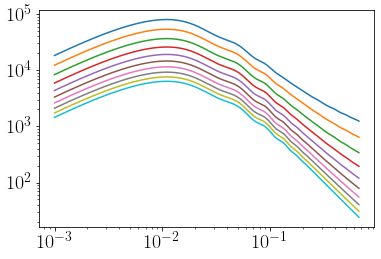

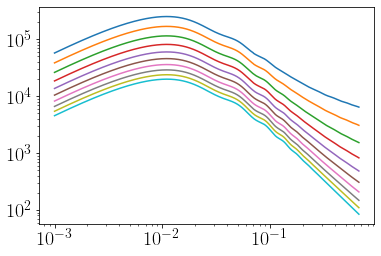

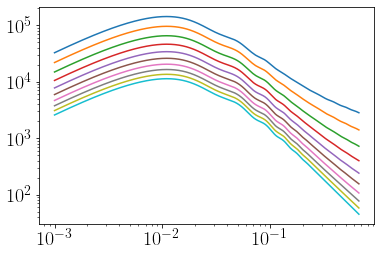

In [12]:
for i in np.arange(start=0,stop=400,step=40):
    plt.plot(k_range, power_spectra[i,0,:])
plt.xscale('log')
plt.yscale('log')
plt.show()

for i in np.arange(start=0,stop=400,step=40):
    plt.plot(k_range, power_spectra[i,1,:])
plt.xscale('log')
plt.yscale('log')
plt.show()

for i in np.arange(start=0,stop=400,step=40):
    plt.plot(k_range, power_spectra[i,2,:])
plt.xscale('log')
plt.yscale('log')
plt.show()

In [13]:
h=0.7

print('starting...')
        
def find_nearest(a, a0):
    "Element in nd array `a` closest to the scalar value `a0`"
    idx = np.abs(a - a0).argmin()
    return idx
kernel = T1.kernels[1]


l = np.arange(10000)
print(l)
C_kk = np.zeros(shape=(q_kappa.shape[0], q_kappa.shape[0], l.shape[0]))
C_dk = np.zeros(shape=(q_delt.shape[0], q_delt.shape[0], l.shape[0]))
C_dd = np.zeros(shape=(q_delt.shape[0], q_delt.shape[0], l.shape[0]))

start = time.time()

C_kk_integrand = np.zeros(shape=(l.shape[0], chi.shape[0]))
C_dk_integrand = np.zeros(shape=(l.shape[0], chi.shape[0]))
C_dd_integrand = np.zeros(shape=(l.shape[0], chi.shape[0]))


for i, nz1 in enumerate([kernel.nzs[2]]):
    for j, nz2 in enumerate([kernel.nzs[2]]):
        print(i,j)        

            #mm_func = interp.interp1d(chi, np.nan_to_num())
        for n, chi_val in enumerate(chi):
            k = (l+1/2)/chi_val
            if chi_val==0:
                continue
            P_mm = interp.interp1d(k_range, power_spectra[n, 0, :], fill_value=power_spectra[n, 0, -1], bounds_error=False)
            P_gg = interp.interp1d(k_range, power_spectra[n, 1, :], fill_value=power_spectra[n, 1, -1], bounds_error=False)
            P_mg = interp.interp1d(k_range, power_spectra[n, 2, :], fill_value=power_spectra[n, 2, -1], bounds_error=False)
            
            C_kk_integrand[:,n] = q_kappa[i+2,n]*q_kappa[j+2,n] / chi_val**2 * P_mm(k)
            C_dk_integrand[:,n] = q_kappa[i+2,n]*q_delt[j+2,n] / chi_val**2 * P_mg(k)
            C_dd_integrand[:,n] = q_delt[i+2,n]*q_delt[j+2,n] / chi_val**2 * P_gg(k)

        C_kk[i+2,j+2, :] = integrate.simps(C_kk_integrand[:, 1::], x=chi[1::], axis=1)
        C_dk[i+2,j+2, :] = integrate.simps(C_dk_integrand[:, 1::], x=chi[1::], axis=1)
        C_dd[i+2,j+2, :] = integrate.simps(C_dd_integrand[:, 1::], x=chi[1::], axis=1)
            #print(C_kk[i,j,l_val], C_dk[i,j,l_val], C_dd[i,j,l_val])
        print('done')

end = time.time()
print(end - start, ' seconds')

IndentationError: unexpected indent (<ipython-input-13-846ed1b7c734>, line 67)

In [ ]:
ell_test = np.loadtxt('ell.txt')
bin_3_3_test = np.loadtxt('bin_3_3.txt')
R = .0002
#plt.plot(l, C_dd[2,2,:])
#plt.plot(l, C_kk[2,2,:])
plt.plot(l, C_dk[2,2,:] * np.exp(-l**2 * R**2))
print(max(ell_test))
plt.plot(ell_test, bin_3_3_test)
plt.ylim(4e-11, 4e-7)
plt.xlim(1,10000)

plt.xlabel('$\ell$')
plt.ylabel('$C^{33}_{\delta \kappa}$')

plt.xscale('log')
plt.yscale('log')
plt.savefig('Ckg_with_IA.png',dpi=200, bbox_inches='tight')
plt.show()

ell_test = np.loadtxt('ell_gg.txt')
bin_3_3_test = np.loadtxt('bin_3_3_gg.txt')

plt.plot(l, C_dd[2,2,:] * np.exp(-l**2 * R**2))

plt.plot(ell_test, bin_3_3_test)
plt.ylim(8e-9, 1e-4)
plt.xlim(1,10000)

plt.xlabel('$\ell$')
plt.ylabel('$C^{33}_{\delta \delta}$')

plt.xscale('log')
plt.yscale('log')
plt.savefig('Cgg.png',dpi=200, bbox_inches='tight')
plt.show()

In [ ]:
x = np.linspace(-1,1,100)

P_0 = special.legendre(0)(x)
P_1 = special.legendre(1)(x)

for ell in np.arange(0, 3):

    if ell==0:
        P_0 = special.legendre(ell)(x)
        plt.plot(x, P_0)
    elif ell==1:
        P_1 = special.legendre(ell)(x)
        plt.plot(x, P_1)
    else:
        P_2 = ((2*(ell-1)+1)*x*P_1 - (ell-1)*P_0)/(ell)
        P_0 = P_1
        P_1 = P_2
        plt.plot(x, P_2)

plt.plot(x, 0.5*(3*x**2 -1))

In [ ]:
import scipy.special as special
R=0.0008
theta = np.logspace(np.log10(2),np.log10(200),100) * (np.pi/(60*180))

for i, nz1 in enumerate([kernel.nzs[2]]):
    for j, nz2 in enumerate([kernel.nzs[2]]):
        
        
        C_dd_interp = interp.interp1d(l, C_dd[2,2,:] * np.exp(-l**2 * R**2))
        #C_dd_interp = interp.interp1d(ell_test, bin_3_3_test, fill_value=(bin_3_3_test[0], bin_3_3_test[-1]), bounds_error=False)
        output1 = np.zeros(shape=len(theta))
        output2 = np.zeros(shape=len(theta))
        
        x = np.cos(theta)
        
        P_0 = special.legendre(0)(x)
        P_1 = special.legendre(1)(x)
        
        for ell in np.arange(0, 10000):
            
            if ell==0:
                output1 += (2*ell+1)/(4*np.pi) * P_0 * C_dd_interp(ell) 
            elif ell==1:
                output1 += (2*ell+1)/(4*np.pi) * P_1 * C_dd_interp(ell) 
            else:
                P_2 = ((2*(ell-1)+1)*x*P_1 - (ell-1)*P_0)/(ell)
                P_0 = P_1
                P_1 = P_2
                
                output1 += (2*ell+1)/(4*np.pi) * P_2 * C_dd_interp(ell) 
                
                
            #* (1- (ell/1000)**10) 
            #* np.cos(np.pi/2 * ell/1000) 
            #* (2*ell+1)/(4*np.pi)
           # output2 += (2*ell+1)/(4*np.pi) * legendre(np.cos(theta)) * C_dd_interp(ell) * np.exp(-ell**2 * R**2) #  (2*ell+1)/(4*np.pi) * 
            
            if np.any(ell == np.array([3000])):
                print(ell)
                plt.plot(theta, output1, label=r'$\ell = $ ' + str(ell))
            #plt.plot(theta, output2, label='us w/ smoothening')

        plt.xscale('log')
        plt.yscale('log')
        
filename1 = 'map_prediction_chain_2x2pt_fixedcosmo_free_mag_pm_samp_buzzard_mean_dv_16_sompz_bin_zs_true_true_zl_no_sn_no_jk_20xrand_bNGcov.fits_scales_3x2pt_0.5_8_6_v0.4.ini_lcdm_scaledrsd.txt'


test = fits.open(filename1 +'.fits')

T1 = twopoint.TwoPointFile.from_fits(filename1 + '.fits')
print(T1)

for spectra in T1.spectra:
    print(spectra.name)
    if spectra.name == 'wtheta':
        i,j = spectra.bin_pairs[3]
        theta, wtheta = spectra.get_pair(i,j)
        plt.plot(theta * np.pi/(60*180), wtheta, label='joe')
        
#plt.xlim(0.01, 0.08)
plt.legend()
plt.ylabel(r'$w_{\theta}$')
plt.xlabel(r'$\theta$ [radians]')
plt.show()      

In [ ]:
R = 0.05

for i, nz1 in enumerate([kernel.nzs[2]]):
    for j, nz2 in enumerate([kernel.nzs[2]]):
        C_kk_interp = interp.interp1d(l, C_kk[i+2,j+2,:])
        C_dk_interp = interp.interp1d(l, C_dk[i+2,j+2,:])
        C_dd_interp = interp.interp1d(l, C_dd[i+2,j+2,:])     
        print(l.shape)
        HankelTransform = SphericalBesselTransform(l)
        print(C_kk[i+2,j+2,:].shape)
        output = HankelTransform.sph(nu=0, fq=(C_kk[i+2,j+2,:]*np.exp(-l**2 * R**2)))
        
        print(len(output))

In [ ]:
plt.plot(output[0]*(60 * 180)/np.pi, output[1][0,:])
plt.yscale('log')
plt.xscale('log')

In [ ]:
filename1 = 'map_prediction_chain_2x2pt_fixedcosmo_free_mag_pm_samp_buzzard_mean_dv_16_sompz_bin_zs_true_true_zl_no_sn_no_jk_20xrand_bNGcov.fits_scales_3x2pt_0.5_8_6_v0.4.ini_lcdm_scaledrsd.txt'


test = fits.open(filename1 +'.fits')

T1 = twopoint.TwoPointFile.from_fits(filename1 + '.fits')
print(T1)

for spectra in T1.spectra:
    print(spectra.name)
    if spectra.name == 'wtheta':
        i,j = spectra.bin_pairs[1]
        theta, wtheta = spectra.get_pair(i,j)
        plt.plot(theta, wtheta)

        print(min(theta), max(theta))
        plt.xscale('log')
        plt.yscale('log')
